# Relative confidence interval for the asymptotic Z test

- Coverage guarantee and lift, % dependence is studied
- Different approaches to the delta method variance formula are covered
- **TODO:** vectorize the simulation loop over the iterations to speed the things up (need to revamp the whole parametrization strategy for it)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import binom, norm, poisson, ttest_ind
from tqdm import tqdm
from pydantic import BaseModel, ConfigDict, model_validator
from typing import Literal


In [2]:
class ZTestConfig(BaseModel):
    model_config = ConfigDict(frozen=True)

    mean_x: float
    mean_y: float
    s2_x: float
    s2_y: float
    s2_yx: float  # covar
    n_obs_x: int
    n_obs_y: int

    @model_validator(mode='after')
    def _validate_stats(self):
        if self.n_obs_x <= 0:
            raise ValueError("n_obs_x must be positive")
        if self.n_obs_y <= 0:
            raise ValueError("n_obs_y must be positive")
        if self.s2_x < 0:
            raise ValueError("s2_x must be non-negative")
        if self.s2_y < 0:
            raise ValueError("s2_y must be non-negative")
        return self


def create_config_from_array(x, y) -> ZTestConfig:
    return ZTestConfig(
        mean_x=np.mean(x),
        mean_y=np.mean(y),
        s2_x=np.var(x, ddof=1),
        s2_y=np.var(y, ddof=1),
        s2_yx=np.cov(y - x, x, ddof=1)[0, 1],
        n_obs_x=np.size(x),
        n_obs_y=np.size(y),
    )


### Stats

In [3]:
def calculate_variance_for_relative_ci(config: ZTestConfig, option='eppo') -> float:
    """
    The variance of the (Y - X) / X fraction calculated using delta method.
    Three options found on the web are presented, see sources below
    """

    mean_y = config.mean_y
    mean_x = config.mean_x
    s2_y = config.s2_y
    s2_x = config.s2_x
    s2_yx = config.s2_yx
    n_obs_y = config.n_obs_y
    n_obs_x = config.n_obs_x

    if mean_x == 0:
        return np.nan

    def _eppo():
        # https://docs.geteppo.com/statistics/confidence-intervals/statistical-nitty-gritty/#frequentist-analysis
        # the same as textbook delta method for the fraction, but the covariance is set to 0 as we expect
        # groups to be independent of each other
        return (s2_y / n_obs_y) / mean_x**2 + (s2_x / n_obs_x) * mean_y**2 / mean_x**4

    def _leave_covar():
        # p235 here: https://alexdeng.github.io/public/files/kdd2018-dm.pdf
        # this is a textbook delta method for the ratio of two means
        # (!) strictly speaking it is defined only for the groups of equal size because of covariance
        # (which is rarely true in typical ab testing systems, but can be hacked via covariance decomposition into means)
        return (
        (s2_y / n_obs_y) / mean_x**2
            + (s2_x / n_obs_x) * mean_y**2 / mean_x**4
            - 2 * (s2_yx / n_obs_x) * mean_y / mean_x**3
            )

    def _avito():
        # https://github.com/DimaLunin/AB_lifehacks/blob/main/ttest.ipynb
        # plug in method from avito (ru marketplace):
        # (1) take the textbook formula (see e.g. Deng) and plug (y-x) in place of y (e.g. var(y) -> var(y-x))
        # (2) estimate cov(y-x, x) as -var(x) (true by the covariance properties)
        # The result exactly matches Eppo's approach (you can prove the equivalence algebraically)
        var_y_x = s2_x / n_obs_x + s2_y / n_obs_y
        covar = - s2_x / n_obs_x
        return (
            var_y_x / mean_x**2
            + (s2_x / n_obs_x) * (mean_y - mean_x)**2 / mean_x**4
            - 2 * covar * (mean_y - mean_x) / mean_x**3
        )

    def _naive():
        return s2_x / n_obs_x + s2_y / n_obs_y

    dispatch = {
        'eppo': _eppo,
        'leave_covar': _leave_covar,
        'avito': _avito,
        'naive': _naive,
    }

    try:
        return dispatch[option]()
    except KeyError:
        raise ValueError("Option must be among eppo, deng, avito or naive")

In [4]:
def create_relative_ci(
    config: ZTestConfig, alpha: float = 0.05,
    var_method: Literal['eppo", "leave_covar', 'avito', 'naive'] = "eppo",
    ) -> tuple[float, float]:
    """
    # Create a & confidence interval for a metric.
    # Naive method is present for the debugging purposes.
    """

    # Validate inputs
    if not (0 < alpha < 1):
        raise ValueError('alpha must be between and 1')

    mean_y = config.mean_y
    mean_x = config.mean_x

    if mean_x == 0:
        return np.nan, np.nan

    diff = mean_y - mean_x
    rel_diff = diff / mean_x

    def _relative_ci(method: str) -> tuple[float, float]:
        variance = calculate_variance_for_relative_ci(config, option=method)
        if not np. isfinite(variance) or variance <= 0:
            return np.nan, np.nan
        norm_with_params = norm(rel_diff, np.sqrt (variance))
        return tuple(norm_with_params.ppf([alpha / 2, 1 - alpha / 2]))

    def _naive_ci() -> tuple[float, float] :
        variance = calculate_variance_for_relative_ci(config, option='naive')
        if not np.isfinite(variance) or variance <= 0:
            return np.nan, np.nan

        norm_with_params = norm(diff, np.sqrt(variance)) # diff here is not relative (!)
        ci_lower, ci_upper = norm_with_params.ppf([alpha / 2, 1 - alpha / 2])
        return ci_lower / mean_x, ci_upper / mean_x

    dispatch = {
        "eppo": lambda: _relative_ci("eppo"),
        "leave_covar": lambda: _relative_ci("leave_covar"),
        "avito": lambda:_relative_ci ("avito"),
        "naive": _naive_ci
    }

    try:
        return dispatch[var_method]()
    except KeyError:
        raise ValueError ("Option must pe one of eppo, fleave_covar, avito or naive")


In [46]:
def get_order_distr(rng, n_obs=1000, zero_share=0.8, base_mean=3):
    """
    Generates data with prespecified mean and % of zeros.
    By specifying the % of zeros you can control data skewness.

    The data legend is that we generate customer orders data with prespecified average number of orders 
    and % of customers with purchases.

    param rng:
    param n_obs:
    param zero_share:
    param n_orders:
    """
    if n_obs < 0:
        raise ValueError('n_customers must be non-negative')
    if not (0 < zero_share < 1):
        raise ValueError ('ctr_to_order must be in (0, 1)')
    if base_mean <= 0:
        raise ValueError( 'n_orders must be non-negative')

    lam = base_mean / (1 - zero_share)
    ctr = rng.binomial(n=1, size=n_obs, p=1-zero_share)
    idx = np.flatnonzero(ctr)

    if idx.size:
        ctr[idx] = rng.poisson(size=idx.size, lam=lam)
    return ctr

In [47]:
def generate_samples(rng, n_obs, base_mean, base_lift, zero_share=0.9):
    """
    Generate control (x) and treatment (y) samples for a given lift.
    """
    x = get_order_distr(
        rng,
        n_obs=n_obs,
        base_mean=base_mean,
        zero_share=zero_share
    )
    y = get_order_distr(
        rng,
        n_obs=n_obs,
        base_mean=base_mean * (1 + base_lift),
        zero_share=zero_share
    )
    return x, y

### Main simulation runner

In [48]:
def run_simulations(
    lifts: np.ndarray,
    n_simulations: int = 1000,
    n_obs_list: np.ndarray[int] = np.array([100, 1000, 10_000, 50_000]),
    alpha: float = 0.05,
    seed: int = 0
) -> dict[int, dict[float, dict]]:
    """
    Function tests the length and coverage of different CI construction methods
    """

    rng = np.random.default_rng(seed)
    results = {n_obs: {} for n_obs in n_obs_list}

    ci_methods = {
        "eppo": lambda cfg: create_relative_ci(cfg, alpha=alpha, var_method="eppo"),
        "leave_covar": lambda cfg: create_relative_ci(cfg, alpha=alpha, var_method="leave_covar"),
        # "avito": lambda cfg: create_relative_ci(cfg, alpha=alpha, var_method="avito"),  # result matches eppo exactly
        "naive": lambda cfg: create_relative_ci(cfg, alpha=alpha, var_method="naive"),
    }

    base_mean = 3

    for n_obs in tqdm(n_obs_list):
      for base_lift in lifts:

        coverage = {method: [] for method in ci_methods}
        statsig = {method: [] for method in ci_methods}

        coverage['abs_ci'] = []
        statsig['abs_ci'] = []
        
        # test mismatch
        abs_relative_coverage_mismatch = []
        abs_relative_statsig_mismatch = []

        for _ in range(n_simulations):
            x, y = generate_samples(
                rng,
                n_obs=n_obs,
                base_mean=base_mean,
                base_lift=base_lift,
                zero_share=0.9,
            )

            params = create_config_from_array(x, y)

            for method, fn in ci_methods.items():
                ci_lower, ci_upper = fn(params)
                coverage[method].append(ci_lower <= base_lift <= ci_upper)
                statsig[method].append(not(ci_lower <= 0 <= ci_upper))

            # Check absolute and relative intervals mismatch:
            # - relative CI covers the effect and the absolute one does not cover it OR vice versa
            # - relative CI shows stat sig result and abs CI does not OR vice versa
            abs_ci_lower, abs_ci_upper = tuple(
                [_ * params.mean_x for _ in list(ci_methods["naive"](params))]
            )

            coverage['abs_ci'].append(abs_ci_lower <= base_mean * base_lift <= abs_ci_upper)
            statsig['abs_ci'].append(not(abs_ci_lower <= 0 <= abs_ci_upper))

            delta_eppo_ci_lower, delta_eppo_ci_upper = ci_methods["eppo"](params)

            effect_capture_disagreement = \
                ((delta_eppo_ci_lower <= base_lift <= delta_eppo_ci_upper)
                and not (abs_ci_lower <= base_mean * base_lift <= abs_ci_upper)) or \
                (not (delta_eppo_ci_lower <= base_lift <= delta_eppo_ci_upper)
                and (abs_ci_lower <= base_mean * base_lift <= abs_ci_upper))

            stat_sig_disagreement = \
                ((delta_eppo_ci_lower <= 0 <= delta_eppo_ci_upper)
                and not (abs_ci_lower <= 0 <= abs_ci_upper)) or \
                (not (delta_eppo_ci_lower <= 0 <= delta_eppo_ci_upper)
                and (abs_ci_lower <= 0 <= abs_ci_upper))

            abs_relative_coverage_mismatch.append(effect_capture_disagreement)
            abs_relative_statsig_mismatch.append(stat_sig_disagreement)

        results[n_obs][base_lift] = {
            "coverage": {k: float(np.mean(v)) for k, v in coverage.items()},
            "statsig": {k: float(np.mean(v)) for k, v in statsig.items()}, # % of statsig results on average = empirical power
            "coverage_disagreement": np.mean(abs_relative_coverage_mismatch),
            "statsig_disagreement": np.mean(abs_relative_statsig_mismatch)
        }

    return results

In [49]:
def plot_results(res: dict[int, dict[float, dict]], eval_metric: str = 'coverage', alpha: float = 0.05) -> None:
    sample_sizes = sorted(res.keys())
    n_facets = len(sample_sizes)

    methods = list(next(iter(next(iter(res.values())).values()))[eval_metric].keys())

    fig, axes = plt.subplots(
        1, n_facets,
        figsize=(5 * n_facets, 5),
        sharex=True,
        sharey=True,
    )

    for ax, sample_size in zip(axes, sample_sizes):
        lifts = sorted(res[sample_size].keys())

        ax.axhline(y=1 - alpha, color='black', linestyle="--")
        for method in methods:
            series = [res[sample_size][k][eval_metric][method] for k in lifts]
            label = f"{method} CI {eval_metric}"
            if method == "naive":
                label = f"divide by control mean CI"
            ax.plot(lifts, series, marker='o', label=label)

        ax.set_title(f'Sample size = {sample_size}')
        ax.set_xlabel('Lift, %')
        ax.set_ylabel(f'{eval_metric}, %, alpha = {alpha}')
        ax.legend(loc='lower left', fontsize='x-small')
        ax.grid(True)

        plt.tight_layout()

    # from pathlib import Path
    # from datetime import datetime
    # _output_dir = Path('plots')
    # _output_dir.mkdir(parents=True, exist_ok=True)
    # _stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # _plot_path = _output_dir / f'coverage_{_stamp}.png'
    # plt.savefig(_plot_path, dpi=200, bbox_inches='tight')

In [50]:
res = run_simulations(lifts=np.arange(5, 105, 5) / 100,
                      alpha=0.05,
                      n_simulations=1000,
                      n_obs_list=[100, 1_000, 10_000, 50_000],
                      seed=2026)

100%|██████████| 4/4 [03:11<00:00, 47.82s/it]


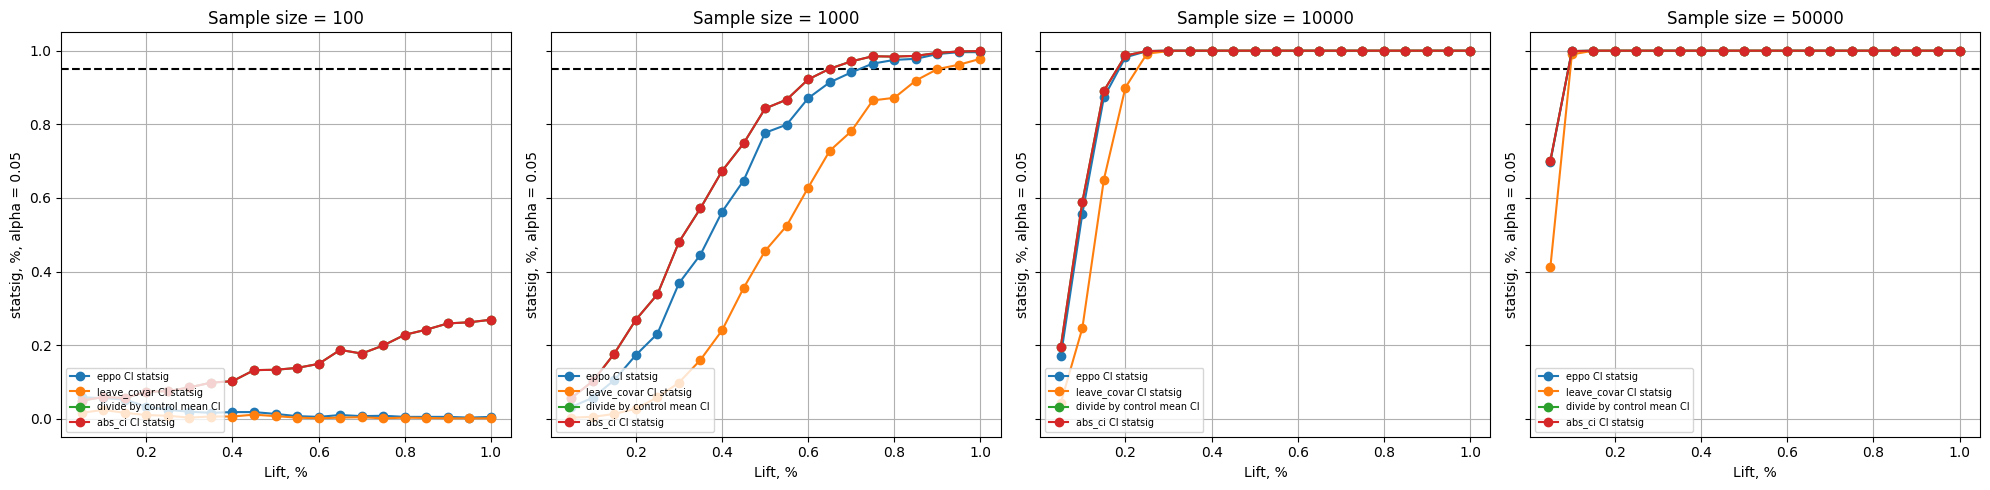

In [42]:
plot_results(res, eval_metric='statsig', alpha=0.05)

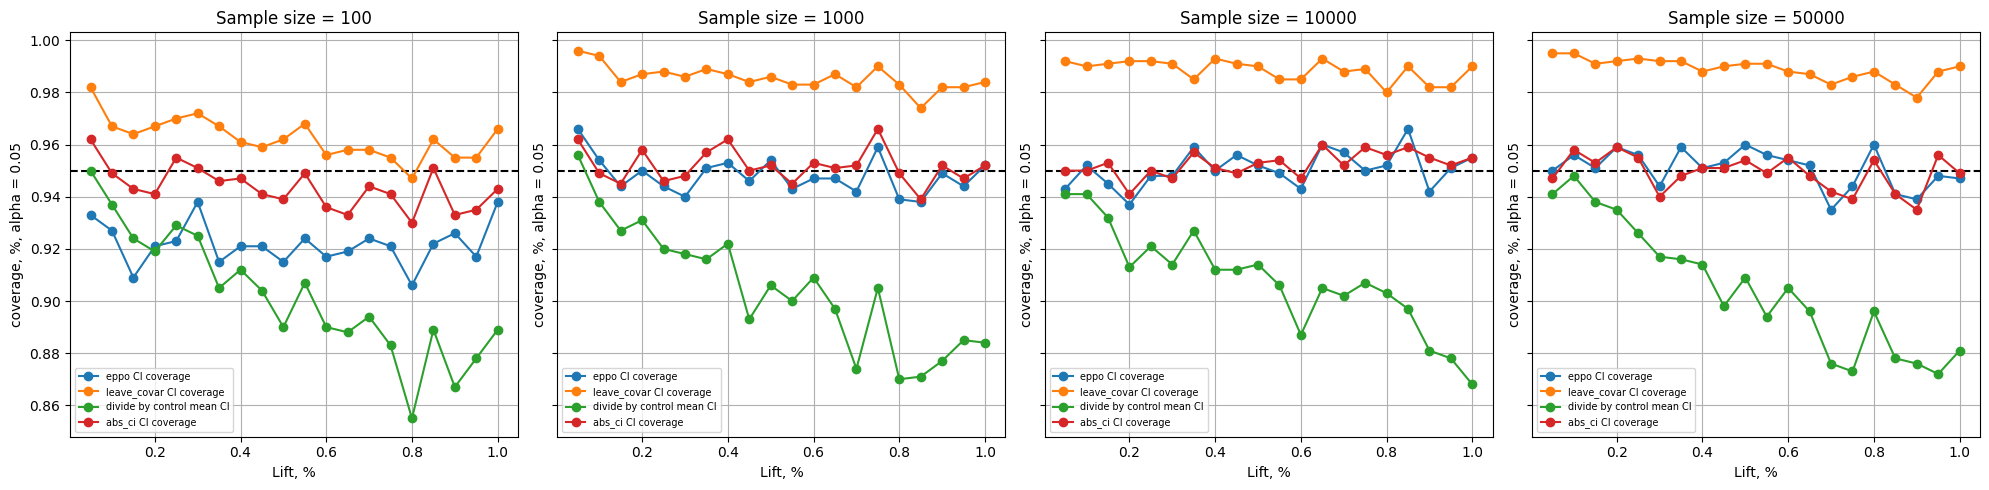

In [43]:
plot_results(res, eval_metric='coverage', alpha=0.05)

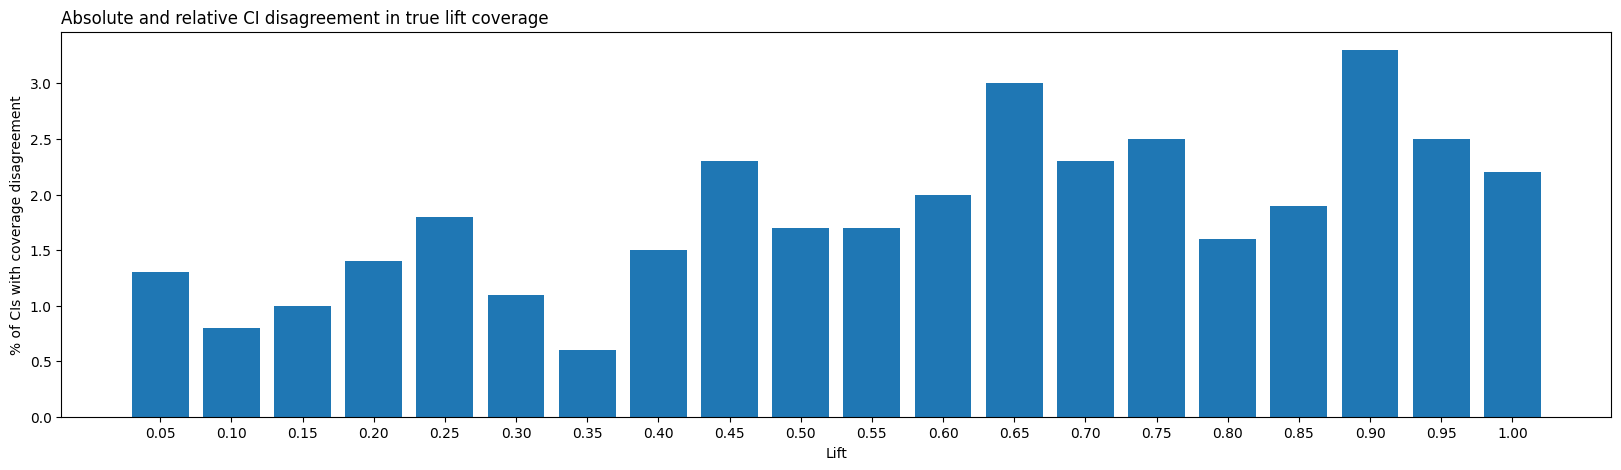

In [44]:
lifts, perc_disagree = zip(*[[k, 100*v['coverage_disagreement']] for k, v in res[10_000].items()])

fig, ax = plt.subplots(figsize=(20,5))

x_positions = np.arange(len(lifts))
ax.bar(x_positions, height=perc_disagree);

ax.set_xticks(x_positions);
ax.set_xticklabels([f'{lift:.2f}' for lift in lifts]);

ax.set_xlabel('Lift');
ax.set_ylabel('% of CIs with coverage disagreement');
ax.set_title('Absolute and relative CI disagreement in true lift coverage', loc='left');

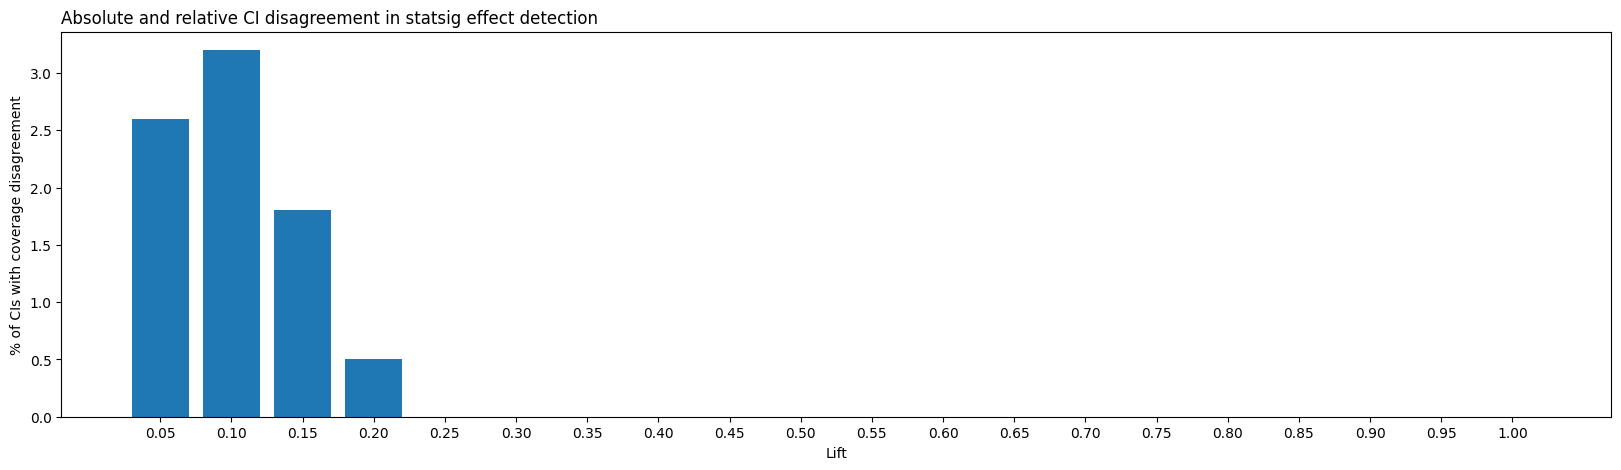

In [45]:
lifts, perc_disagree = zip(*[[k, 100*v['statsig_disagreement']] for k, v in res[10_000].items()])

fig, ax = plt.subplots(figsize=(20,5))

x_positions = np.arange(len(lifts))
ax.bar(x_positions, height=perc_disagree);

ax.set_xticks(x_positions);
ax.set_xticklabels([f'{lift:.2f}' for lift in lifts]);

ax.set_xlabel('Lift');
ax.set_ylabel('% of CIs with coverage disagreement');
ax.set_title('Absolute and relative CI disagreement in statsig effect detection', loc='left');

## Covar

In [96]:
rng_cov = np.random.default_rng(20)
y = rng_cov.normal(loc=3, scale=1, size=1000)
x = rng_cov.normal(loc=2, scale=1, size=1000)

manual_sample_covar = (len(x) / (len(x) - 1)) * (np.mean(x*y) - np.mean(x) * np.mean(y)) # length for x is chosen randomly, could have been y
np_sample_covar = np.cov(y, x, ddof=1)[0,1]

print(f'Numpy sample covar is: {np_sample_covar}')
print(f'Manually calculated sample covar is: {manual_sample_covar}')

Numpy sample covar is: -0.017974270280274023
Manually calculated sample covar is: -0.01797427028027354


In [ ]:
covs = []
for _ in range(1000):

    x, y = generate_samples(rng_cov, n_obs=1000, base_mean=3, base_lift=0.1)

    cv = np.cov(y, x)[0, 1]
    covs.append(cv)

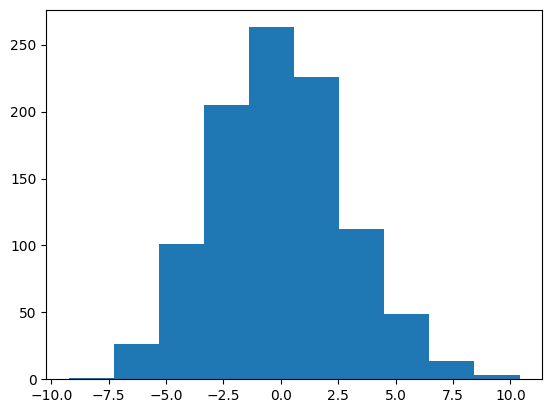

In [90]:
import matplotlib.pyplot as plt

plt.hist(covs);